# Eye-tracking via Convolutional Neural Network

# Introduction

A convolutional nerual network (or CNN) is a deep learning algorithm which takes an input image and assigns importance ( learnable differences) to various aspects or objects in the image to differentiate one from another. This can be applied in many powerful machine learning applications, such as eye tracking. The goal of this report is to use a CNN to determine the (x,y) location of the center of the pupil in images of eyes. The effect of some network hyper-parameter on performance will also be studied to see how that changes accuracy. Any alterations should have somewhat of a difference on accuracy of predicted (x,y) values and actual (x,y) values. 

# What is an Epoch?


One epoch is when an entire dataset is passed forward and backward through the neural network. If 3 epochs are ran, the entire dataset is passed forward and back 3 times, and so on. Running the program with more epochs should give higher accuracy because the algorithm can greater optimize the learning process. It is important to keep in mind that one epoch is too much to run for a computer, so the epoch is divided into smaller batches that are run back and forth through. If there are 8 batches and 1 epoch, for example, the epoch would run through 8 images back and forth and continue until the whole dataset is parsed through. It is a bit more difficult to find the right amount of batches. For this report, the epoch size will be made variable as we see how increasing or decreasing the batches affects accuracy.

# Setup

We must work with a set of images that we can train the algorithm on and test for accuracy. "draw_one_eye.py" is a python file that uses Inkscape (a vector graphics software) to create a set of 1000 images of single eyes with different (x,y) values of locations for pupils. The locations are also mapped in a text file so that we may compare the actual values to the predicted values. Note: The text file is edited manually to include an "x y" at the top to label the columns.

In [1]:
#run draw_one_eye.py

In [2]:
from IPython.display import Image
Image("0000_one_eye_x2.427_y-10.086.png")

# Code

After running the "draw_one_eye.py," we will now run our CNN on the set of images. Tensorflow is platform that allows for the building and deployment of machine learning models that can be trained. After creating the CNN, we run our model on the images for 20 epochs, which is 20 cycles through all 8  batches. One key set of data we get that we will continue working with is the "preds" and the "testa" values. The "preds" is the predicted (x,y) values our CNN predicted based on what it learned while parsing over the images of the eyes. The "testa" is the actual (x,y) values we got from the "draw_one_eye.py".

In [3]:
# Adapted from Adrian Rosebrock https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/

# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# build the network

def create_cnn(width, height, depth, nfilters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, nf) in enumerate(nfilters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(nf, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer: JR not sure what the role of this is
    x = Dense(4)(x)
    x = Activation("relu")(x)

    x = Dense(2, activation="linear")(x)    ################  2D output

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

import glob
import cv2

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib.pyplot as plt
from os.path import join
from glob import glob
import pandas
from PIL import Image

def setup(datafolder, columns_to_use ):

    datafile   = join( datafolder , datafolder+'.txt' )
    # construct the path to the input .txt file that contains information
    # on each image in the dataset and then load the dataset
    print("Loading attributes...")
    
    #df = load_attributes(inputPath)  # replace with direct code to load attributes
    # df should be a numpy array with only the desired columns
    df = pandas.read_csv(datafile, sep=' ')[ columns_to_use ].copy()

    # load the images and then scale the pixel intensities to the
    # range [0, 1]
    print("Loading images...")
    #images = load_images(df, datafolder)#
    imagefiles = sorted( glob( join(datafolder,'*.png')   ))
    
    #images = np.array([cv2.imread(imagefile)[:,:,:3] for imagefile in imagefiles ])  # slice off opacity layer
    # Instead use PIL.Image to avoid problems some are having with installing opencv (cv2)
    images = np.array([np.array(Image.open(imagefile))[:,:,:3] for imagefile in imagefiles ])  # slice off opacity layer
    print(images.shape)
    images = images / 255.0

    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    #split = train_test_split(df, images, test_size=0.25, random_state=42)   # can alternatively make your own function to do this
    #(trainAttrX, testAttrX, trainImagesX, testImagesX) = split
    
    # Trying to get rid of dependencies: I coded train/test split from scratch instead of using sklearn
    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    nimages = len(images)
    ntest = int( nimages * 0.25 )
    intest = np.zeros(nimages,dtype=bool)
    intest[ np.random.choice( np.arange(nimages), ntest, replace=False ) ] = True
    intrain = ~intest
    testImagesX  = images[intest ,:,:,:].copy()
    trainImagesX = images[intrain,:,:,:].copy()
    testAttrX  = df.values[intest ,:]
    trainAttrX = df.values[intrain,:]
    
    # to rescale trainY and testY
    minAttr = trainAttrX.min(axis=0)
    maxAttr = trainAttrX.max(axis=0)
    rangeAttr = maxAttr - minAttr
    
    trainAttrX -= minAttr
    trainAttrX = (trainAttrX/rangeAttr)
    
    testAttrX -= minAttr
    testAttrX = (testAttrX/rangeAttr)
    
    # let's return minAttr and rangeAttr for use in interpretation of predictions
    return trainAttrX,testAttrX, trainImagesX, testImagesX, minAttr, rangeAttr
    

tra,testa,tri,testi, mina,rangea = setup('one_eye_12',['x', 'y'])
print(mina,rangea)

# create our Convolutional Neural Network and then compile the model
# using mean squared error as our loss

#print(tri.shape)
nimages,h,w,depth = tri.shape

model = create_cnn(w,h, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)  # more sophisticated than plain gradient descent
model.compile(loss="mean_squared_error", optimizer=opt)

# train the model
print("Training model...")
model.fit(tri,tra, validation_data=(testi, testa),
        epochs=20, batch_size=8)

#model.save('model.h5')  # in case we want to take up training from were we left off

# make predictions on the testing data
print("Predicting")
preds = model.predict(testi)
# undo rescaling and shifting of data
preds = preds*rangea + mina  # predictions of network
testa = testa*rangea + mina  # actual values
# next: compare (graphically) predictions with actual values

Loading attributes...
Loading images...
(1000, 24, 45, 3)
[-39.976 -14.918] [79.968 29.914]
Training model...
Train on 750 samples, validate on 250 samples
Epoch 1/20
750/750 [==============================] - 4s 6ms/sample - loss: 0.4368 - val_loss: 1.4346
Epoch 2/20
750/750 [==============================] - 2s 3ms/sample - loss: 0.2072 - val_loss: 3.8568
Epoch 3/20
750/750 [==============================] - 2s 3ms/sample - loss: 0.1395 - val_loss: 0.9355
Epoch 4/20
750/750 [==============================] - 2s 3ms/sample - loss: 0.0935 - val_loss: 0.1232
Epoch 5/20
750/750 [==============================] - 2s 2ms/sample - loss: 0.0806 - val_loss: 0.0315
Epoch 6/20
750/750 [==============================] - 2s 2ms/sample - loss: 0.0650 - val_loss: 0.0205
Epoch 7/20
750/750 [==============================] - 2s 3ms/sample - loss: 0.0583 - val_loss: 0.0184
Epoch 8/20
750/750 [==============================] - 2s 2ms/sample - loss: 0.0482 - val_loss: 0.0165
Epoch 9/20
750/750 [========

Here, "ypreds", "ytesta", "xpreds", "xtesta" are created so that we may apply the root mean square error function, which is used to measure the differences between values predicted by a model or an estimator and the values observed. It is a good way to measure accuracy and compare errors. 

In [4]:
xpreds = preds[:,0]
xtesta = testa[:,0]
ypreds = preds[:,1]
ytesta = testa[:,1]
n=len(preds)
xerror = np.sqrt( ((xpreds-xtesta)**2).sum()/n)
yerror = np.sqrt( ((ypreds-ytesta)**2).sum()/n)
print("X error: ", xerror)
print("Y error: ",yerror)

X error:  6.659528522473819
Y error:  2.9079305004849476


Now, we will utilize a basic version of the confusion matrix, which is a performance measurement for machine learning classification. It is usually table with 4 combinations of predicted and actual values. There is true positive (predicted postive and it's true), true negative (predicted negative and it's true), false positive (predicted positive but it's false) and false negative ( you predicted negative and it's false). We describe predicted values as positives and negatives and actual values as true and false. With the confusion matrix we can display accuracy, rates of miscalculations, precision, etc. The graphs that I am displaying are just the "xtesta" vs "xpreds" and "ytesta" vs "ypreds" which essentially display the accuracy of our program.

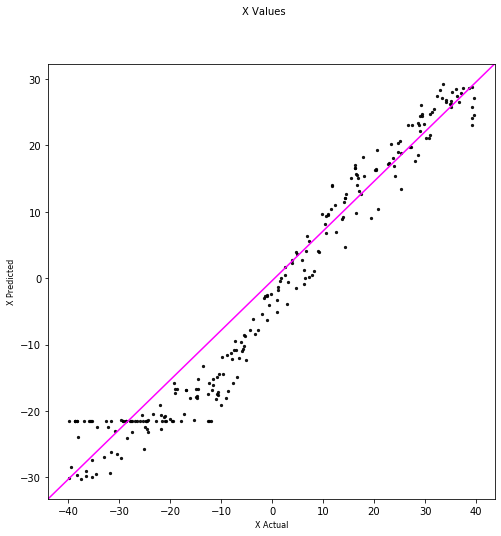

In [5]:
#x values
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.scatter(xtesta, xpreds, c="black",s=5,alpha=0.9)
plt.suptitle('X Values', fontsize=10)
plt.xlabel('X Actual', fontsize=8)
plt.ylabel('X Predicted', fontsize=8)
#plt.subplot(1,1,1, aspect=1)
ax = plt.gca()
ax.plot([0,1],[0,1], transform=ax.transAxes, c = "magenta")

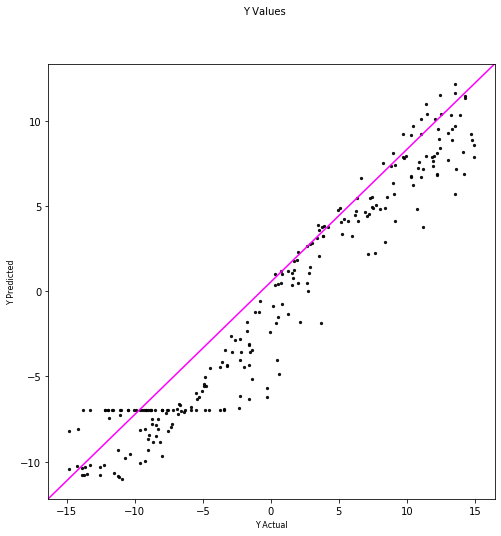

In [6]:
#y values
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.scatter(ytesta, ypreds, c="black",s=5,alpha=0.9)
plt.suptitle('Y Values', fontsize=10)
plt.xlabel('Y Actual', fontsize=8)
plt.ylabel('Y Predicted', fontsize=8)
ax = plt.gca()
ax.plot([0,1],[0,1], transform=ax.transAxes, c = "magenta")

We can see that there is still a high rate of error based on the RMS function and the plots. By increasing the number of epochs there should be an increase in accuracy of the program. 


# Increasing Epoch size

In [7]:
def create_cnn(width, height, depth, nfilters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, nf) in enumerate(nfilters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(nf, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer: JR not sure what the role of this is
    x = Dense(4)(x)
    x = Activation("relu")(x)

    x = Dense(2, activation="linear")(x)    ################  2D output

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model



def setup(datafolder, columns_to_use ):

    datafile   = join( datafolder , datafolder+'.txt' )
    # construct the path to the input .txt file that contains information
    # on each image in the dataset and then load the dataset
    print("Loading attributes...")
    
    #df = load_attributes(inputPath)  # replace with direct code to load attributes
    # df should be a numpy array with only the desired columns
    df = pandas.read_csv(datafile, sep=' ')[ columns_to_use ].copy()

    # load the images and then scale the pixel intensities to the
    # range [0, 1]
    print("Loading images...")
    #images = load_images(df, datafolder)#
    imagefiles = sorted( glob( join(datafolder,'*.png')   ))
    
    #images = np.array([cv2.imread(imagefile)[:,:,:3] for imagefile in imagefiles ])  # slice off opacity layer
    # Instead use PIL.Image to avoid problems some are having with installing opencv (cv2)
    images = np.array([np.array(Image.open(imagefile))[:,:,:3] for imagefile in imagefiles ])  # slice off opacity layer
    print(images.shape)
    images = images / 255.0

    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    #split = train_test_split(df, images, test_size=0.25, random_state=42)   # can alternatively make your own function to do this
    #(trainAttrX, testAttrX, trainImagesX, testImagesX) = split
    
    # Trying to get rid of dependencies: I coded train/test split from scratch instead of using sklearn
    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    nimages = len(images)
    ntest = int( nimages * 0.25 )
    intest = np.zeros(nimages,dtype=bool)
    intest[ np.random.choice( np.arange(nimages), ntest, replace=False ) ] = True
    intrain = ~intest
    testImagesX  = images[intest ,:,:,:].copy()
    trainImagesX = images[intrain,:,:,:].copy()
    testAttrX  = df.values[intest ,:]
    trainAttrX = df.values[intrain,:]
    
    # to rescale trainY and testY
    minAttr = trainAttrX.min(axis=0)
    maxAttr = trainAttrX.max(axis=0)
    rangeAttr = maxAttr - minAttr
    
    trainAttrX -= minAttr
    trainAttrX = (trainAttrX/rangeAttr)
    
    testAttrX -= minAttr
    testAttrX = (testAttrX/rangeAttr)
    
    # let's return minAttr and rangeAttr for use in interpretation of predictions
    return trainAttrX,testAttrX, trainImagesX, testImagesX, minAttr, rangeAttr
    

tra,testa,tri,testi, mina,rangea = setup('one_eye_12',['x', 'y'])
print(mina,rangea)

# create our Convolutional Neural Network and then compile the model
# using mean squared error as our loss

#print(tri.shape)
nimages,h,w,depth = tri.shape

model = create_cnn(w,h, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)  # more sophisticated than plain gradient descent
model.compile(loss="mean_squared_error", optimizer=opt)

# train the model
print("Training model...")
model.fit(tri,tra, validation_data=(testi, testa),
        epochs=300, batch_size=8)

#model.save('model.h5')  # in case we want to take up training from were we left off

# make predictions on the testing data
print("Predicting")
preds = model.predict(testi)
# undo rescaling and shifting of data
preds = preds*rangea + mina  # predictions of network
testa = testa*rangea + mina  # actual values
# next: compare (graphically) predictions with actual values

Loading attributes...
Loading images...
(1000, 24, 45, 3)
[-39.976 -14.918] [79.968 29.881]
Training model...
Train on 750 samples, validate on 250 samples
Epoch 1/300
750/750 [==============================] - 4s 5ms/sample - loss: 0.4013 - val_loss: 0.2862
Epoch 2/300
750/750 [==============================] - 2s 3ms/sample - loss: 0.1905 - val_loss: 0.1752
Epoch 3/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.1212 - val_loss: 0.3142
Epoch 4/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0931 - val_loss: 0.3068
Epoch 5/300
750/750 [==============================] - 2s 3ms/sample - loss: 0.0800 - val_loss: 0.1519
Epoch 6/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0677 - val_loss: 0.0767
Epoch 7/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0600 - val_loss: 0.0395
Epoch 8/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0562 - val_loss: 0.0274
Epoch 9/300
750/750 

750/750 [==============================] - 2s 2ms/sample - loss: 0.0306 - val_loss: 0.0109
Epoch 79/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0319 - val_loss: 0.0074
Epoch 80/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0305 - val_loss: 0.0069
Epoch 81/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0327 - val_loss: 0.0072
Epoch 82/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0314 - val_loss: 0.0066
Epoch 83/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0310 - val_loss: 0.0061
Epoch 84/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0301 - val_loss: 0.0091
Epoch 85/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0315 - val_loss: 0.0081
Epoch 86/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0315 - val_loss: 0.0066
Epoch 87/300
750/750 [==============================] - 2s 2ms/sample - loss:

750/750 [==============================] - 2s 2ms/sample - loss: 0.0281 - val_loss: 0.0064
Epoch 157/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0297 - val_loss: 0.0054
Epoch 158/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0302 - val_loss: 0.0038
Epoch 159/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0302 - val_loss: 0.0061
Epoch 160/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0295 - val_loss: 0.0089
Epoch 161/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0279 - val_loss: 0.0089
Epoch 162/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0285 - val_loss: 0.0065
Epoch 163/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0302 - val_loss: 0.0061
Epoch 164/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0305 - val_loss: 0.0060
Epoch 165/300
750/750 [==============================] - 2s 2ms/sampl

750/750 [==============================] - 2s 2ms/sample - loss: 0.0239 - val_loss: 0.0050
Epoch 235/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0257 - val_loss: 0.0044
Epoch 236/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0244 - val_loss: 0.0040
Epoch 237/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0246 - val_loss: 0.0062
Epoch 238/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0232 - val_loss: 0.0085
Epoch 239/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0255 - val_loss: 0.0040
Epoch 240/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0220 - val_loss: 0.0039
Epoch 241/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0246 - val_loss: 0.0035
Epoch 242/300
750/750 [==============================] - 2s 2ms/sample - loss: 0.0237 - val_loss: 0.0043
Epoch 243/300
750/750 [==============================] - 2s 2ms/sampl

We can see that increasing the epoch size has a significant decrease in error, especially for the x values. This is expected as a repeated passes over the data would allow the program to decipher better. 

In [13]:
xpreds = preds[:,0]
xtesta = testa[:,0]
ypreds = preds[:,1]
ytesta = testa[:,1]
n=len(preds)
xerror = np.sqrt( ((xpreds-xtesta)**2).sum()/n)
yerror = np.sqrt( ((ypreds-ytesta)**2).sum()/n)
print("X error: ", xerror)
print("Y error: ",yerror)

X error:  4.919533934238812
Y error:  2.2480464347800564


In [14]:
#x values
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.scatter(nxtesta, nxpreds, c="black",s=5,alpha=0.9)
plt.suptitle('X Values', fontsize=10)
plt.xlabel('X Actual', fontsize=8)
plt.ylabel('X Predicted', fontsize=8)
#plt.subplot(1,1,1, aspect=1)
ax = plt.gca()
ax.plot([0,1],[0,1], transform=ax.transAxes, c = "magenta")


NameError: name 'nxtesta' is not defined

It was a bit difficult to scale the y values graph to properly show accuracy

In [15]:
#y values
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.scatter(nytesta, nypreds, c="black",s=5,alpha=0.9)
plt.suptitle('Y Values', fontsize=10)
plt.xlabel('Y Actual', fontsize=8)
plt.ylabel('Y Predicted', fontsize=8)
ax = plt.gca()
plt.ylim(-12,5)
ax.plot([0,1],[0,1], transform=ax.transAxes, c = "magenta")

NameError: name 'nytesta' is not defined

# Changing Iris Color

Now we will see if changing the color of the iris will have any effect on the accuracy of the program. The color for the iris of the images generated with the "draw_one_eye" will be changed to #5bb1cd, which is a light blue. 

In [ ]:
run draw_blue_eye.py

In [ ]:
from IPython.display import Image
Image("0000_one_eye_x14.134_y-12.355.png")

In [ ]:
def create_cnn(width, height, depth, nfilters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, nf) in enumerate(nfilters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(nf, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer: JR not sure what the role of this is
    x = Dense(4)(x)
    x = Activation("relu")(x)

    x = Dense(2, activation="linear")(x)    ################  2D output

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

def setup(datafolder, columns_to_use ):

    datafile   = join( datafolder , datafolder+'.txt' )
    # construct the path to the input .txt file that contains information
    # on each image in the dataset and then load the dataset
    print("Loading attributes...")
    
    #df = load_attributes(inputPath)  # replace with direct code to load attributes
    # df should be a numpy array with only the desired columns
    df = pandas.read_csv(datafile, sep=' ')[ columns_to_use ].copy()

    # load the images and then scale the pixel intensities to the
    # range [0, 1]
    print("Loading images...")
    #images = load_images(df, datafolder)#
    imagefiles = sorted( glob( join(datafolder,'*.png')   ))
    
    #images = np.array([cv2.imread(imagefile)[:,:,:3] for imagefile in imagefiles ])  # slice off opacity layer
    # Instead use PIL.Image to avoid problems some are having with installing opencv (cv2)
    images = np.array([np.array(Image.open(imagefile))[:,:,:3] for imagefile in imagefiles ])  # slice off opacity layer
    print(images.shape)
    images = images / 255.0

    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    #split = train_test_split(df, images, test_size=0.25, random_state=42)   # can alternatively make your own function to do this
    #(trainAttrX, testAttrX, trainImagesX, testImagesX) = split
    
    # Trying to get rid of dependencies: I coded train/test split from scratch instead of using sklearn
    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    nimages = len(images)
    ntest = int( nimages * 0.25 )
    intest = np.zeros(nimages,dtype=bool)
    intest[ np.random.choice( np.arange(nimages), ntest, replace=False ) ] = True
    intrain = ~intest
    testImagesX  = images[intest ,:,:,:].copy()
    trainImagesX = images[intrain,:,:,:].copy()
    testAttrX  = df.values[intest ,:]
    trainAttrX = df.values[intrain,:]
    
    # to rescale trainY and testY
    minAttr = trainAttrX.min(axis=0)
    maxAttr = trainAttrX.max(axis=0)
    rangeAttr = maxAttr - minAttr
    
    trainAttrX -= minAttr
    trainAttrX = (trainAttrX/rangeAttr)
    
    testAttrX -= minAttr
    testAttrX = (testAttrX/rangeAttr)
    
    # let's return minAttr and rangeAttr for use in interpretation of predictions
    return trainAttrX,testAttrX, trainImagesX, testImagesX, minAttr, rangeAttr
    

tra,testa,tri,testi, mina,rangea = setup('blue_eye',['x', 'y'])
print(mina,rangea)

# create our Convolutional Neural Network and then compile the model
# using mean squared error as our loss

#print(tri.shape)
nimages,h,w,depth = tri.shape

model = create_cnn(w,h, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)  # more sophisticated than plain gradient descent
model.compile(loss="mean_squared_error", optimizer=opt)

# train the model
print("Training model...")
model.fit(tri,tra, validation_data=(testi, testa),
        epochs=20, batch_size=8)

#model.save('model.h5')  # in case we want to take up training from were we left off

# make predictions on the testing data
print("Predicting")
preds = model.predict(testi)
# undo rescaling and shifting of data
preds = preds*rangea + mina  # predictions of network
testa = testa*rangea + mina  # actual values
# next: compare (graphically) predictions with actual values

Now, we will test the error for 20 epochs of blue eye. The blue eye color seems to increase precision on the x value but the y value seems to have a slightly higher error.

In [ ]:
xpreds = preds[:,0]
xtesta = testa[:,0]
ypreds = preds[:,1]
ytesta = testa[:,1]
n=len(preds)
xerror = np.sqrt( ((xpreds-xtesta)**2).sum()/n)
yerror = np.sqrt( ((ypreds-ytesta)**2).sum()/n)
print("X error: ", xerror)
print("Y error: ",yerror)

Increasing the epochs should make a more noticeable difference for us to see if changing the iris color to a lighter shade has any difference.

In [ ]:
def create_cnn(width, height, depth, nfilters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, nf) in enumerate(nfilters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(nf, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer: JR not sure what the role of this is
    x = Dense(4)(x)
    x = Activation("relu")(x)

    x = Dense(2, activation="linear")(x)    ################  2D output

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

def setup(datafolder, columns_to_use ):

    datafile   = join( datafolder , datafolder+'.txt' )
    # construct the path to the input .txt file that contains information
    # on each image in the dataset and then load the dataset
    print("Loading attributes...")
    
    #df = load_attributes(inputPath)  # replace with direct code to load attributes
    # df should be a numpy array with only the desired columns
    df = pandas.read_csv(datafile, sep=' ')[ columns_to_use ].copy()

    # load the images and then scale the pixel intensities to the
    # range [0, 1]
    print("Loading images...")
    #images = load_images(df, datafolder)#
    imagefiles = sorted( glob( join(datafolder,'*.png')   ))
    
    #images = np.array([cv2.imread(imagefile)[:,:,:3] for imagefile in imagefiles ])  # slice off opacity layer
    # Instead use PIL.Image to avoid problems some are having with installing opencv (cv2)
    images = np.array([np.array(Image.open(imagefile))[:,:,:3] for imagefile in imagefiles ])  # slice off opacity layer
    print(images.shape)
    images = images / 255.0

    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    #split = train_test_split(df, images, test_size=0.25, random_state=42)   # can alternatively make your own function to do this
    #(trainAttrX, testAttrX, trainImagesX, testImagesX) = split
    
    # Trying to get rid of dependencies: I coded train/test split from scratch instead of using sklearn
    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    nimages = len(images)
    ntest = int( nimages * 0.25 )
    intest = np.zeros(nimages,dtype=bool)
    intest[ np.random.choice( np.arange(nimages), ntest, replace=False ) ] = True
    intrain = ~intest
    testImagesX  = images[intest ,:,:,:].copy()
    trainImagesX = images[intrain,:,:,:].copy()
    testAttrX  = df.values[intest ,:]
    trainAttrX = df.values[intrain,:]
    
    # to rescale trainY and testY
    minAttr = trainAttrX.min(axis=0)
    maxAttr = trainAttrX.max(axis=0)
    rangeAttr = maxAttr - minAttr
    
    trainAttrX -= minAttr
    trainAttrX = (trainAttrX/rangeAttr)
    
    testAttrX -= minAttr
    testAttrX = (testAttrX/rangeAttr)
    
    # let's return minAttr and rangeAttr for use in interpretation of predictions
    return trainAttrX,testAttrX, trainImagesX, testImagesX, minAttr, rangeAttr
    

tra,testa,tri,testi, mina,rangea = setup('blue_eye',['x', 'y'])
print(mina,rangea)

# create our Convolutional Neural Network and then compile the model
# using mean squared error as our loss

#print(tri.shape)
nimages,h,w,depth = tri.shape

model = create_cnn(w,h, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)  # more sophisticated than plain gradient descent
model.compile(loss="mean_squared_error", optimizer=opt)

# train the model
print("Training model...")
model.fit(tri,tra, validation_data=(testi, testa),
        epochs=300, batch_size=8)

#model.save('model.h5')  # in case we want to take up training from were we left off

# make predictions on the testing data
print("Predicting")
preds = model.predict(testi)
# undo rescaling and shifting of data
preds = preds*rangea + mina  # predictions of network
testa = testa*rangea + mina  # actual values
# next: compare (graphically) predictions with actual values

We can see that the error decreases significantly, but there seems to be not much of a difference between the brown iris images.

In [ ]:
xpreds = preds[:,0]
xtesta = testa[:,0]
ypreds = preds[:,1]
ytesta = testa[:,1]
n=len(preds)
xerror = np.sqrt( ((xpreds-xtesta)**2).sum()/n)
yerror = np.sqrt( ((ypreds-ytesta)**2).sum()/n)
print("X error: ", xerror)
print("Y error: ",yerror)

# Conclusion

As expected, higher epoch size(which allowed for more passes over the images of the eyes) created a higher precision in identifying the x and y coordinates of the position of the iris. There were limitations as running 300 epochs took a significant amount of time. Running 1000 epochs should theoretically increase the accuracy down to a very small percent of error, but a stronger computer or more time is needed to run that. There seemed to be no real effect on changing the iris color to a slightly lighter and different shade on performance either. If anything, it created a slight increase in percent error when running a higher number of epochs. The CNN itself is pretty accurate in identifying the position of the iris. I am sure if given enough epochs (and perhaps a trial and error on varying batch size) you could get the error down to an almost negligible amount.

# Resources

CNN Code and draw_one_eye.py from Day-2 of Mth 448: 
http://blue.math.buffalo.edu/448/



Plot help: 
https://jakevdp.github.io/PythonDataScienceHandbook/04.02-simple-scatter-plots.html


https://stackoverflow.com/questions/25497402/adding-y-x-to-a-matplotlib-scatter-plot-if-i-havent-kept-track-of-all-the-data

https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger
http://pyhogs.github.io/plot-aspect-ratio.html

CNN: 
https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

Confusion Matrix help: 
https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62  